# Forecasting Traffic Flow in densely populated areas using Neural Networks

### Libraries

In [2]:
# Data Collection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

# Data Cleaning
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
# Normalazation
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# Feature Selection
import seaborn as sns
# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# Model Training
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Phase 1 - Data Collection: 1 hour Interval

In [54]:
df = pd.read_csv('8_15MINS_FULL_DATA.csv')
df.isnull().sum()  
df.head()

DateTime  vehicle_count_per_hour  Total Per Hour         Day  \
0  01/08/2023 00:00                       0             NaN  01/08/2023   
1  01/08/2023 00:15                       0             NaN  01/08/2023   
2  01/08/2023 00:30                       0             NaN  01/08/2023   
3  01/08/2023 00:45                       0             0.0  01/08/2023   
4  01/08/2023 01:00                       0             NaN  01/08/2023   

       Time  temp  feelslike  humidity   dew  precip  ...  windgust  \
0  00:00:00  26.9       29.2     74.82  22.1     0.0  ...      25.9   
1  00:00:00  26.9       29.2     74.82  22.1     0.0  ...      25.9   
2  00:00:00  26.9       29.2     74.82  22.1     0.0  ...      25.9   
3  00:00:00  26.9       29.2     74.82  22.1     0.0  ...      25.9   
4  01:00:00  26.8       28.9     74.11  21.8     0.0  ...      20.5   

   windspeed  winddir  pressure  visibility  cloudcover  solarradiation  \
0       25.9    310.0    1010.9        16.6         0.0             NaN   
1       25.9    310.0    1010.9        16.6         0.0             NaN   
2       25.9    310.0    1010.9        16.6         0.0             NaN   
3       25.9    310.0    1010.9        16.6         0.0             NaN   
4       19.5    330.0    1010.7        14.1         0.0             NaN   

   solarenergy  uvindex  conditions  
0          NaN      NaN       Clear  
1          NaN      NaN       Clear  
2          NaN      NaN       Clear  
3          NaN      NaN       Clear  
4          NaN      NaN       Clear  

[5 rows x 21 columns]

## Phase 2 - Preprocessing

### Data Cleaning

#### Remove unnecessary data fields

In [55]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M') 

df['hour_of_day'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek
df['month'] = df['DateTime'].dt.month
df['day_of_year'] = df['DateTime'].dt.day_of_year


# Convert 'Day' column to datetime
df['Day'] = pd.to_datetime(df['Day'], format='%d/%m/%Y')

# Extract the day of the week, where Monday=1, ..., Sunday=7
df['day_of_week'] = df['Day'].dt.dayofweek + 1

In [56]:
#df = df.drop('PH', axis=1)
#df = df.drop('icon', axis=1)
df = df.drop('Day', axis=1) # For weather column
df = df.drop('Time', axis=1)
df = df.drop('Total Per Hour', axis=1)
# df = df.drop('datetimeEpoch', axis=1)

df.head()

DateTime  vehicle_count_per_hour  temp  feelslike  humidity  \
0 2023-08-01 00:00:00                       0  26.9       29.2     74.82   
1 2023-08-01 00:15:00                       0  26.9       29.2     74.82   
2 2023-08-01 00:30:00                       0  26.9       29.2     74.82   
3 2023-08-01 00:45:00                       0  26.9       29.2     74.82   
4 2023-08-01 01:00:00                       0  26.8       28.9     74.11   

    dew  precip  precipprob  windgust  windspeed  ...  visibility  cloudcover  \
0  22.1     0.0           0      25.9       25.9  ...        16.6         0.0   
1  22.1     0.0           0      25.9       25.9  ...        16.6         0.0   
2  22.1     0.0           0      25.9       25.9  ...        16.6         0.0   
3  22.1     0.0           0      25.9       25.9  ...        16.6         0.0   
4  21.8     0.0           0      20.5       19.5  ...        14.1         0.0   

   solarradiation  solarenergy  uvindex  conditions  hour_of_day day_of_week  \
0             NaN          NaN      NaN       Clear            0           2   
1             NaN          NaN      NaN       Clear            0           2   
2             NaN          NaN      NaN       Clear            0           2   
3             NaN          NaN      NaN       Clear            0           2   
4             NaN          NaN      NaN       Clear            1           2   

   month  day_of_year  
0      8          213  
1      8          213  
2      8          213  
3      8          213  
4      8          213  

[5 rows x 22 columns]

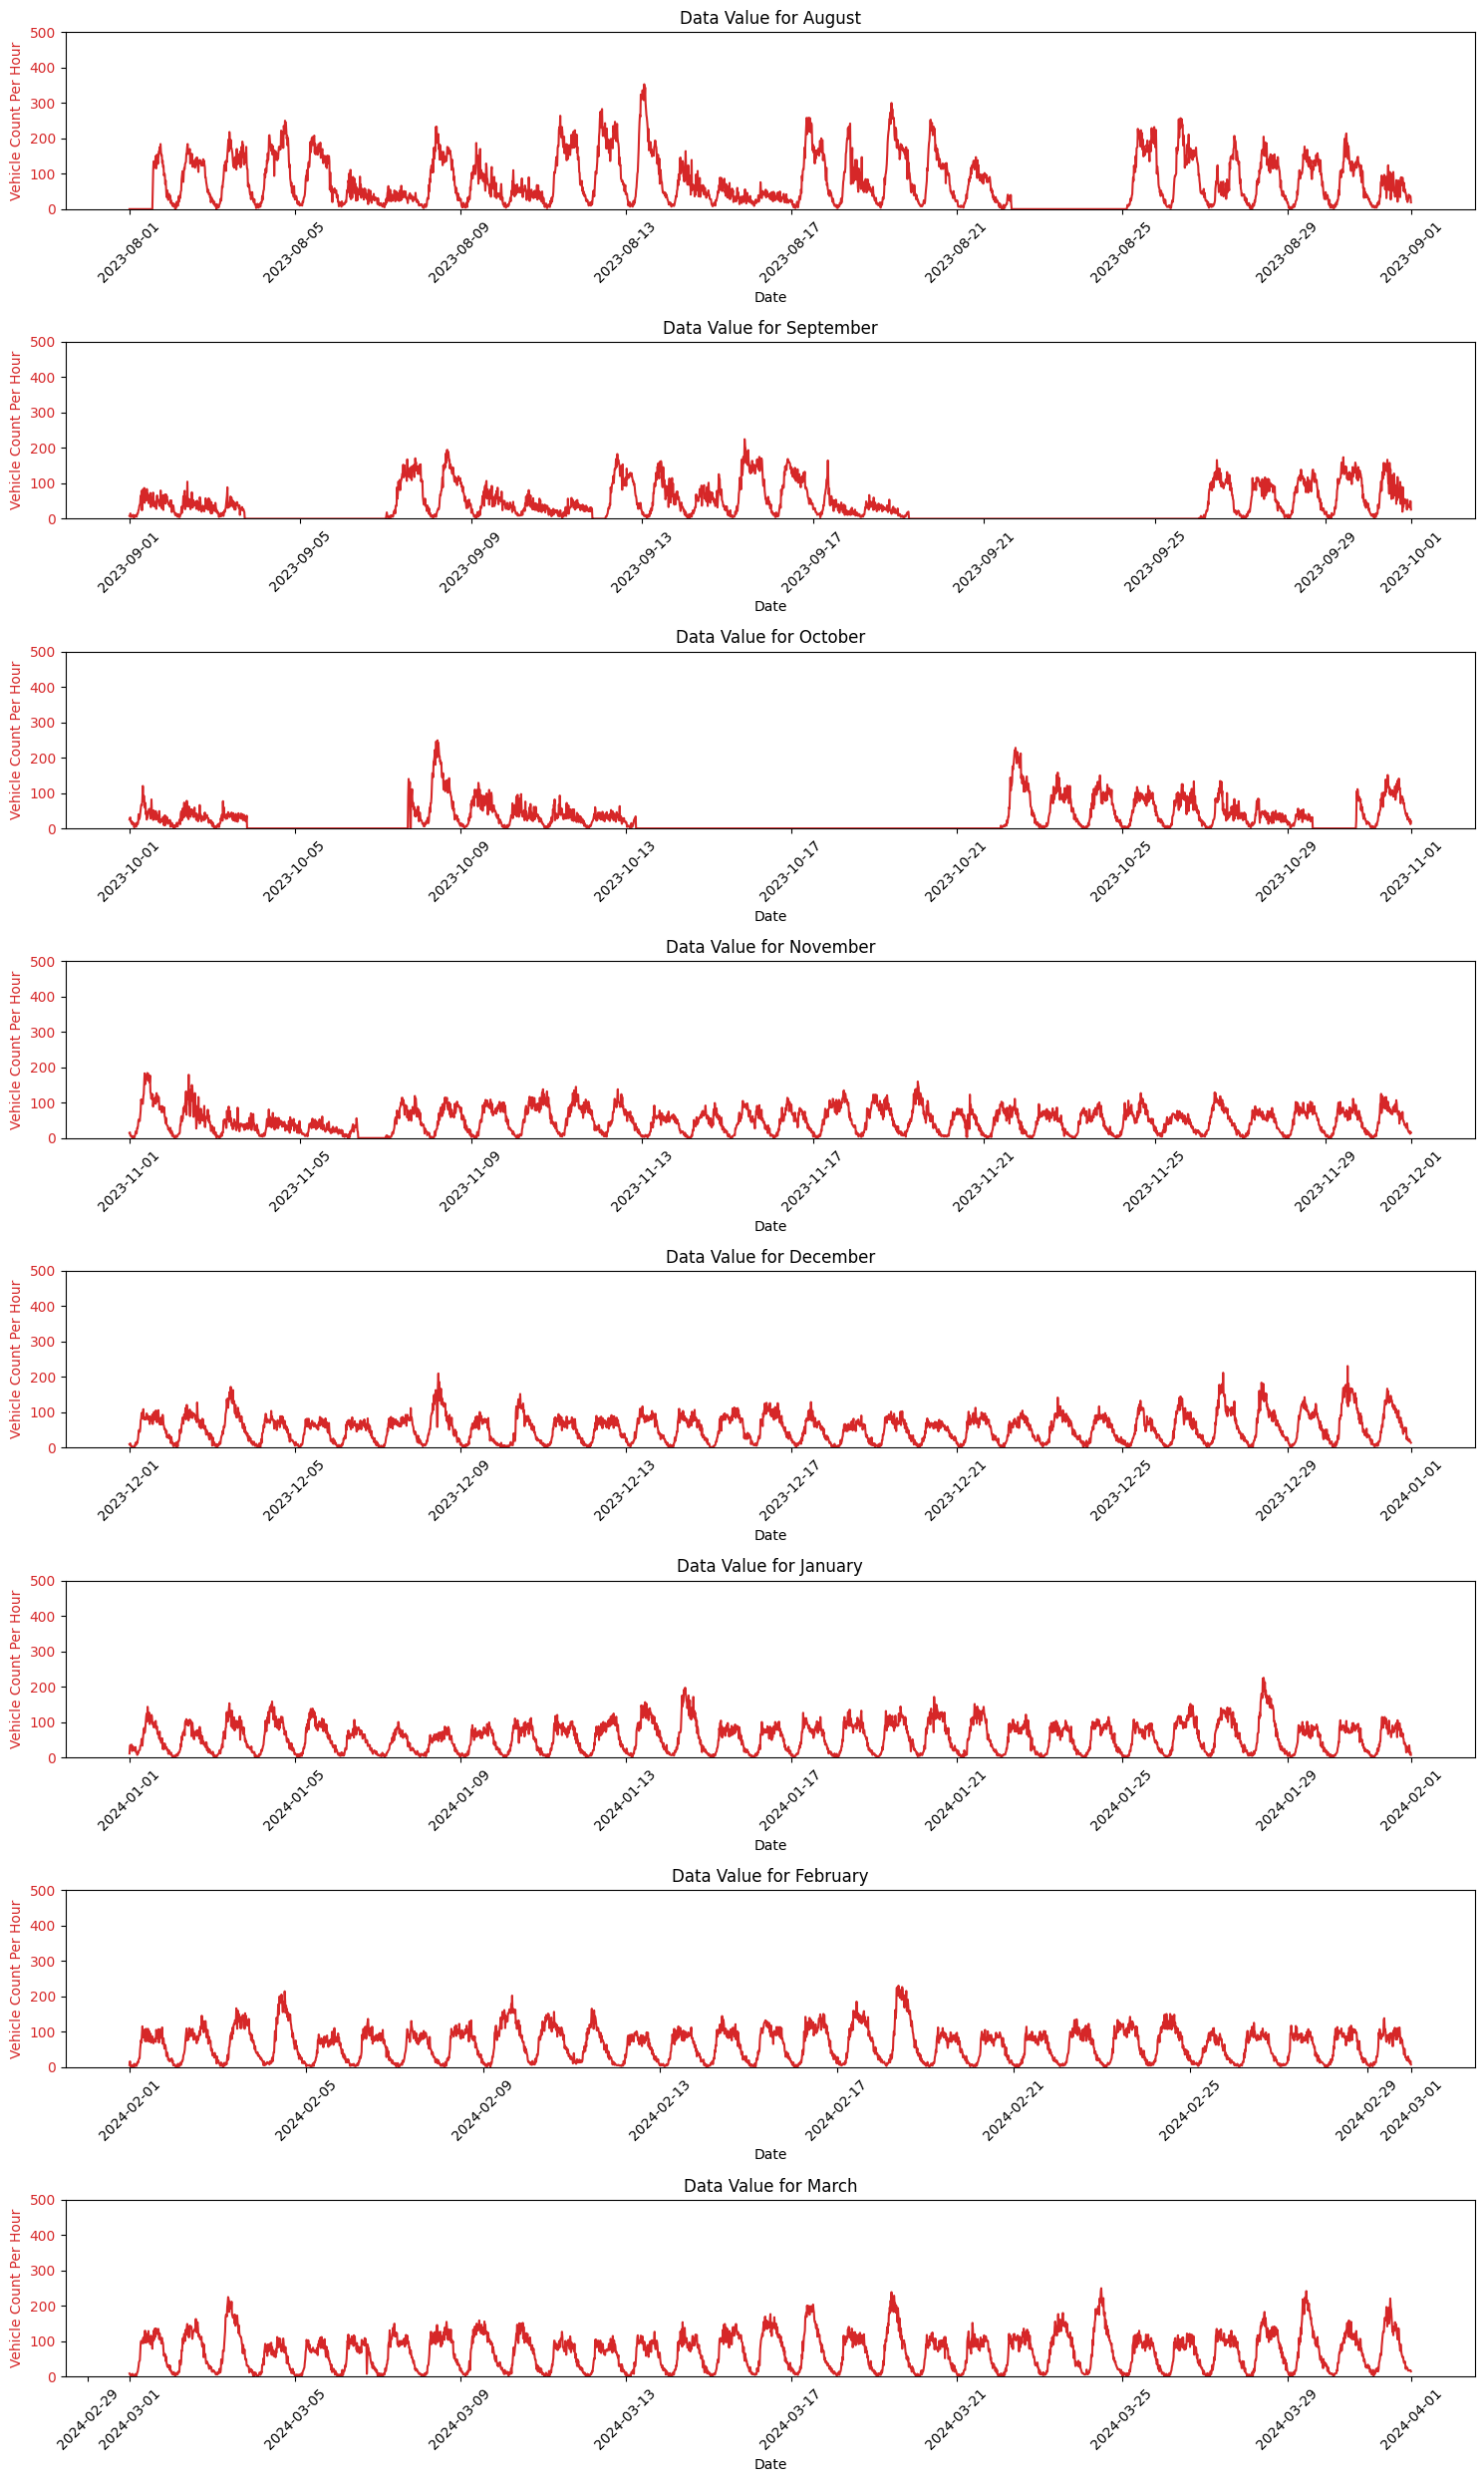

In [57]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your DataFrame
# Ensure 'DateTime' is in datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Extract month from 'DateTime' for filtering
df['month'] = df['DateTime'].dt.month

# Set up the figure size and layout
plt.figure(figsize=(15, 25))

# Names of the months for labeling purposes
month_names = ['August', 'September', 'October', 'November', 'December', 'January', 'February', 'March']

# Indices of the months you want to plot
months_to_plot = [8, 9, 10, 11, 12, 1, 2, 3]

for i, month in enumerate(months_to_plot, start=1):
    ax1 = plt.subplot(8, 1, i)  # Create a subplot for each month and get the first axis
    
    # Filter data for the current month
    month_data = df[df['month'] == month]
    
    # Plotting vehicle count per hour on the primary y-axis
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Vehicle Count Per Hour', color=color)
    ax1.plot(month_data['DateTime'], month_data['vehicle_count_per_hour'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim([0, 500])  # Adjust y-axis to always have a max of 1200 for vehicle count
    
    plt.title(f'Data Value for {month_names[i-1]}')
    plt.xticks(rotation=45)  # Rotate date labels for better readability
    plt.tight_layout()  # Adjust subplots to fit in the figure area

plt.show()


#### Handling missing Data

#### Using KNN

In [58]:
# Create the imputer object. You can adjust 'n_neighbors' as appropriate for your data.
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Prepare the data by selecting only the numeric columns that do not have missing values to be used as predictors
# and the ones with missing values that need to be imputed.
columns_for_imputation = ['vehicle_count_per_hour']
predictor_columns = df.select_dtypes(include=[np.number]).columns.drop(columns_for_imputation)

# Impute missing values using KNN
df_imputed = knn_imputer.fit_transform(df[predictor_columns.union(columns_for_imputation)])

# The output is a numpy array, so if you want it back in a DataFrame, ensure to keep the original index:
df_imputed = pd.DataFrame(df_imputed, columns=predictor_columns.union(columns_for_imputation), index=df.index)

# Now update the original DataFrame with the imputed values for the specified columns
df[columns_for_imputation] = df_imputed[columns_for_imputation]

# Check your DataFrame to make sure the missing data has been imputed
print(df[columns_for_imputation].head())

# Save the DataFrame to an Excel file
df.to_excel('9_Handling_Missing_Data_Pre-processing.xlsx', index=False)

   vehicle_count_per_hour
0                     0.0
1                     0.0
2                     0.0
3                     0.0
4                     0.0


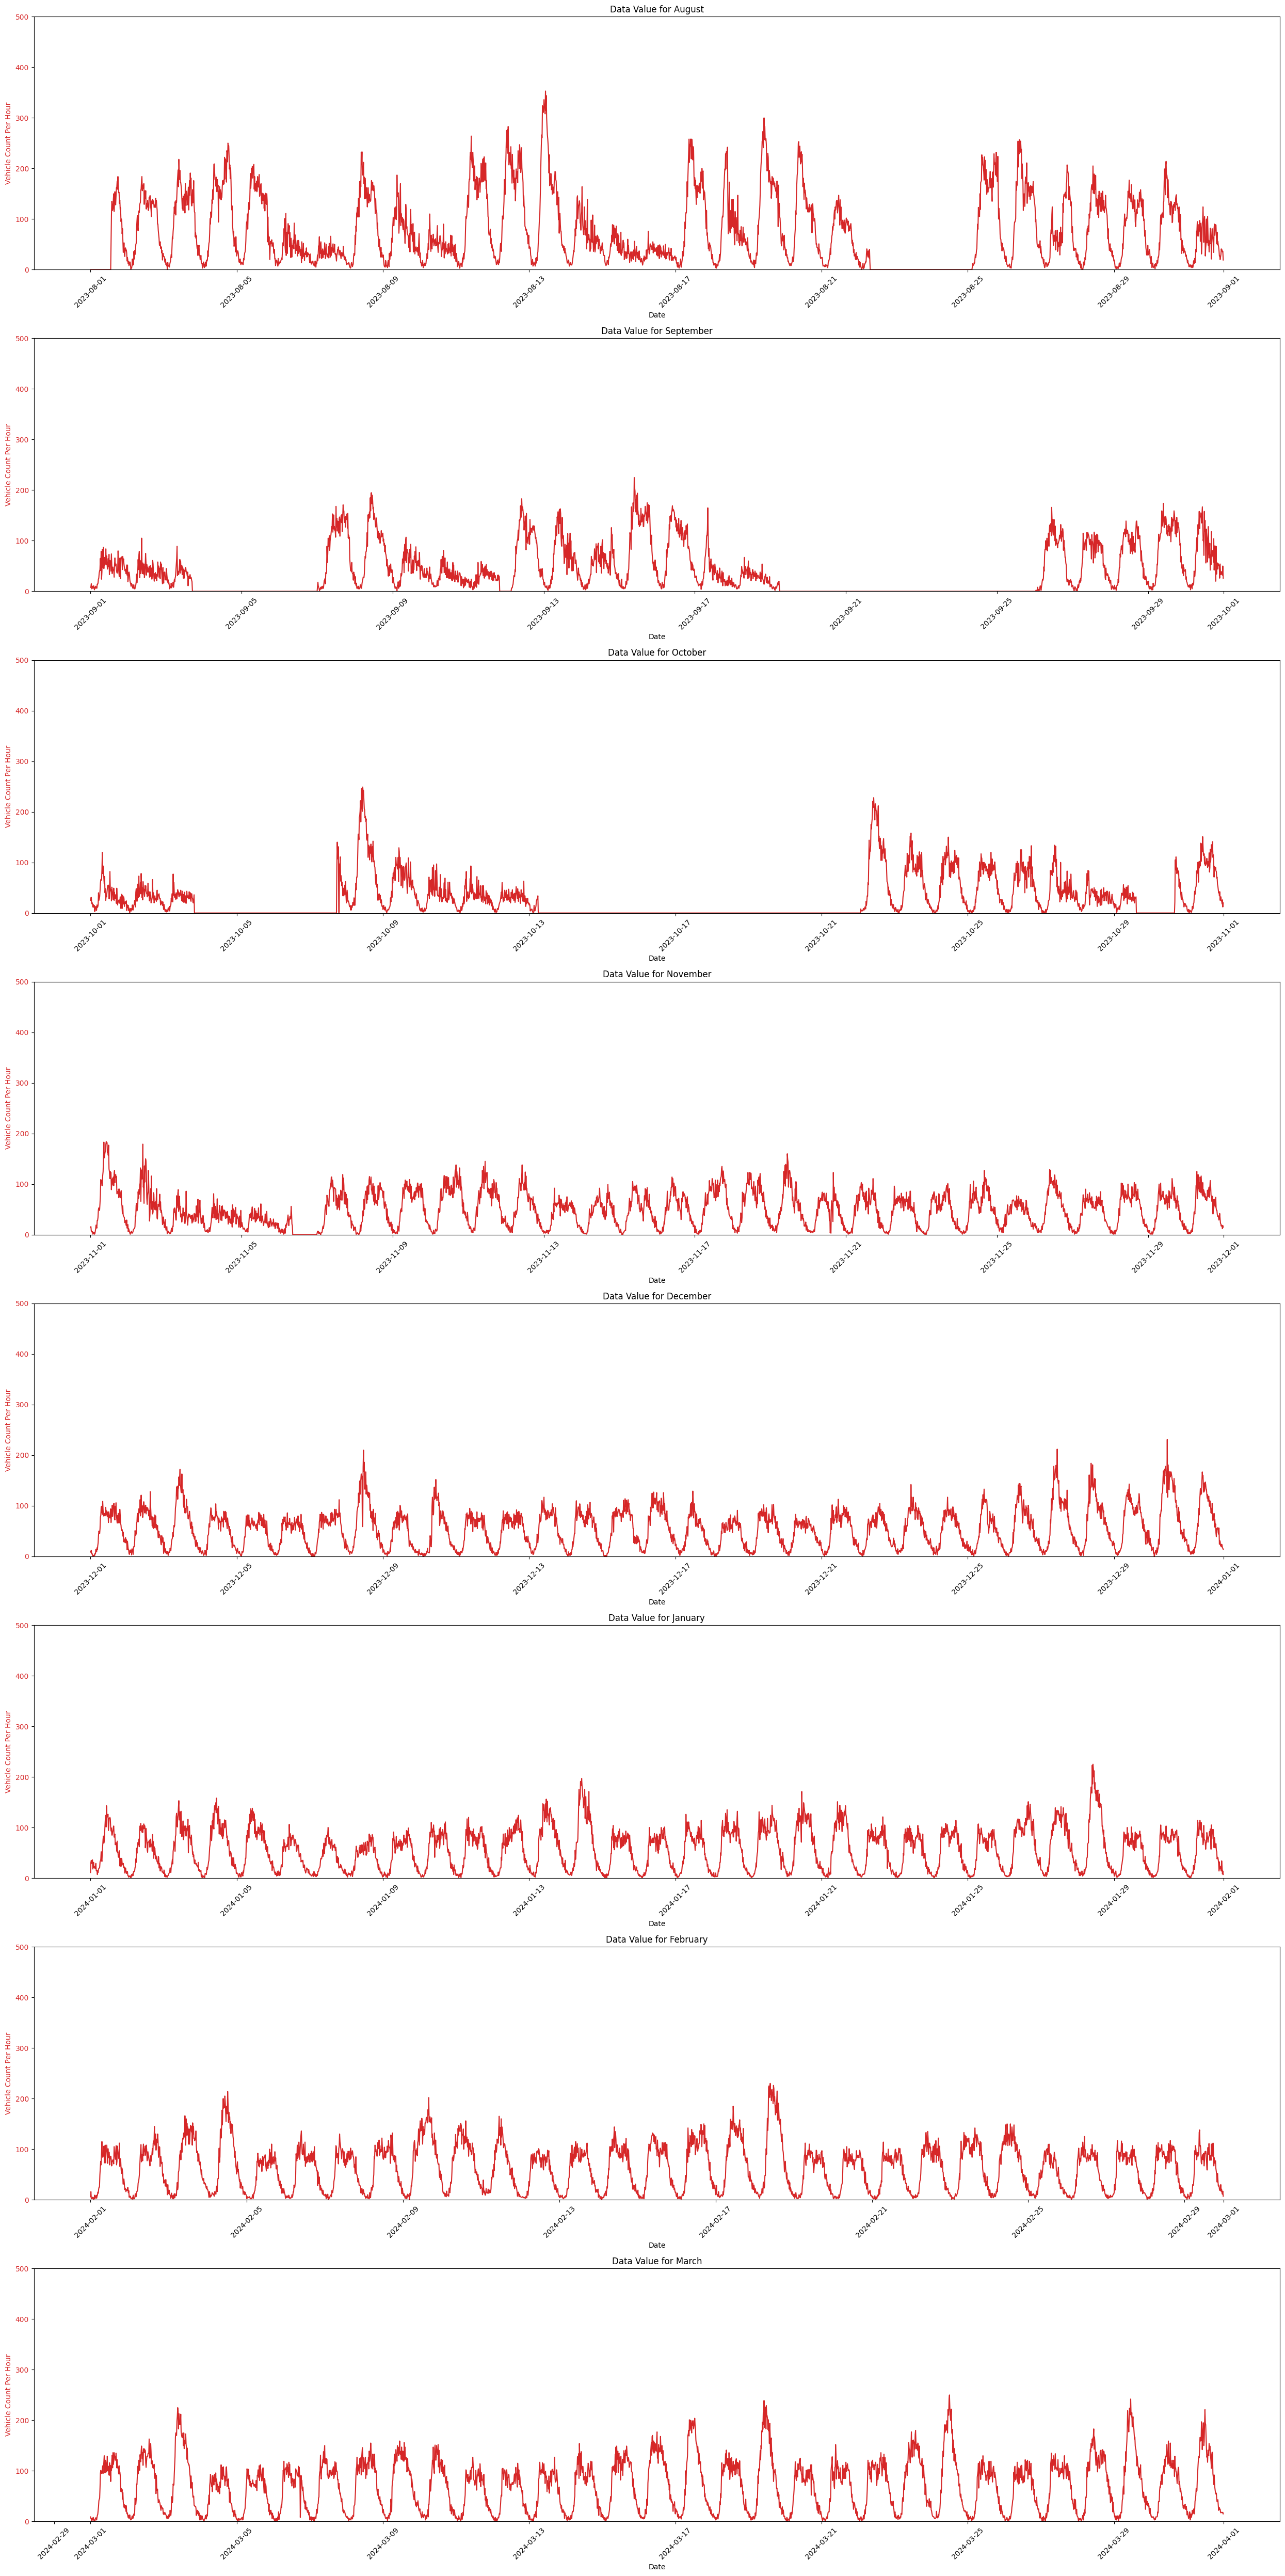

In [59]:
# Assuming the 'Month' column has already been added to df
df['Month'] = df['DateTime'].dt.month

# Set up the figure size and layout
plt.figure(figsize=(25, 50))

# Names of the months for labeling purposes
month_names = ['August', 'September', 'October', 'November', 'December', 'January', 'February','March']

# Indices of the months you want to plot (exclude March to July)
months_to_plot = [8, 9, 10, 11, 12, 1, 2, 3]

for i, month in enumerate(months_to_plot, start=1):
    ax1 = plt.subplot(8, 1, i)  # Create a subplot for each month and get the first axis
    
    # Filter data for the current month
    month_data = df[df['Month'] == month]
    
    # Plotting vehicle count per hour on the primary y-axis
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Vehicle Count Per Hour', color=color)
    ax1.plot(month_data['DateTime'], month_data['vehicle_count_per_hour'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim([0, 500])  # Adjust y-axis to always have a max of 1200 for vehicle count
    

    plt.title(f'Data Value for {month_names[i-1]}')
    plt.xticks(rotation=45)  # Rotate date labels for better readability
    plt.tight_layout()  # Adjust subplots to fit in the figure area

plt.show()


#### Not Using Random Forest

In [45]:
# Split the data based on missing 'vehicle_count_per_hour' or 'average_speed_per_hour'
df_not_missing_vc = df.dropna(subset=['vehicle_count_per_hour'])
df_missing_vc = df[df['vehicle_count_per_hour'].isna()]

# Assuming 'hour', 'day_of_week', and any other relevant features are your predictors

# For 'vehicle_count_per_hour'
X_vc = df_not_missing_vc[['hour_of_day', 'day_of_week']]  # Add more features as needed
y_vc = df_not_missing_vc['vehicle_count_per_hour']

model_vc = RandomForestRegressor(n_estimators=100)
model_vc.fit(X_vc, y_vc)

if not df_missing_vc.empty:
    X_missing_vc = df_missing_vc[['hour_of_day', 'day_of_week']]
    predicted_vc = model_vc.predict(X_missing_vc)
    df.loc[df['vehicle_count_per_hour'].isna(), 'vehicle_count_per_hour'] = predicted_vc

# Check null values
print(df.isnull().sum())

# Save the DataFrame to an Excel file
df.to_excel('9_Handling_Missing_Data_Pre-processing.xlsx', index=False)


DateTime                      0
vehicle_count_per_hour        0
temp                          0
feelslike                     0
humidity                      0
dew                           0
precip                        0
precipprob                    0
windgust                      0
windspeed                     0
winddir                       0
pressure                      0
visibility                  572
cloudcover                    0
solarradiation            10228
solarenergy               10228
uvindex                   10228
conditions                    0
hour_of_day                   0
day_of_week                   0
month                         0
day_of_year                   0
Month                         0
dtype: int64


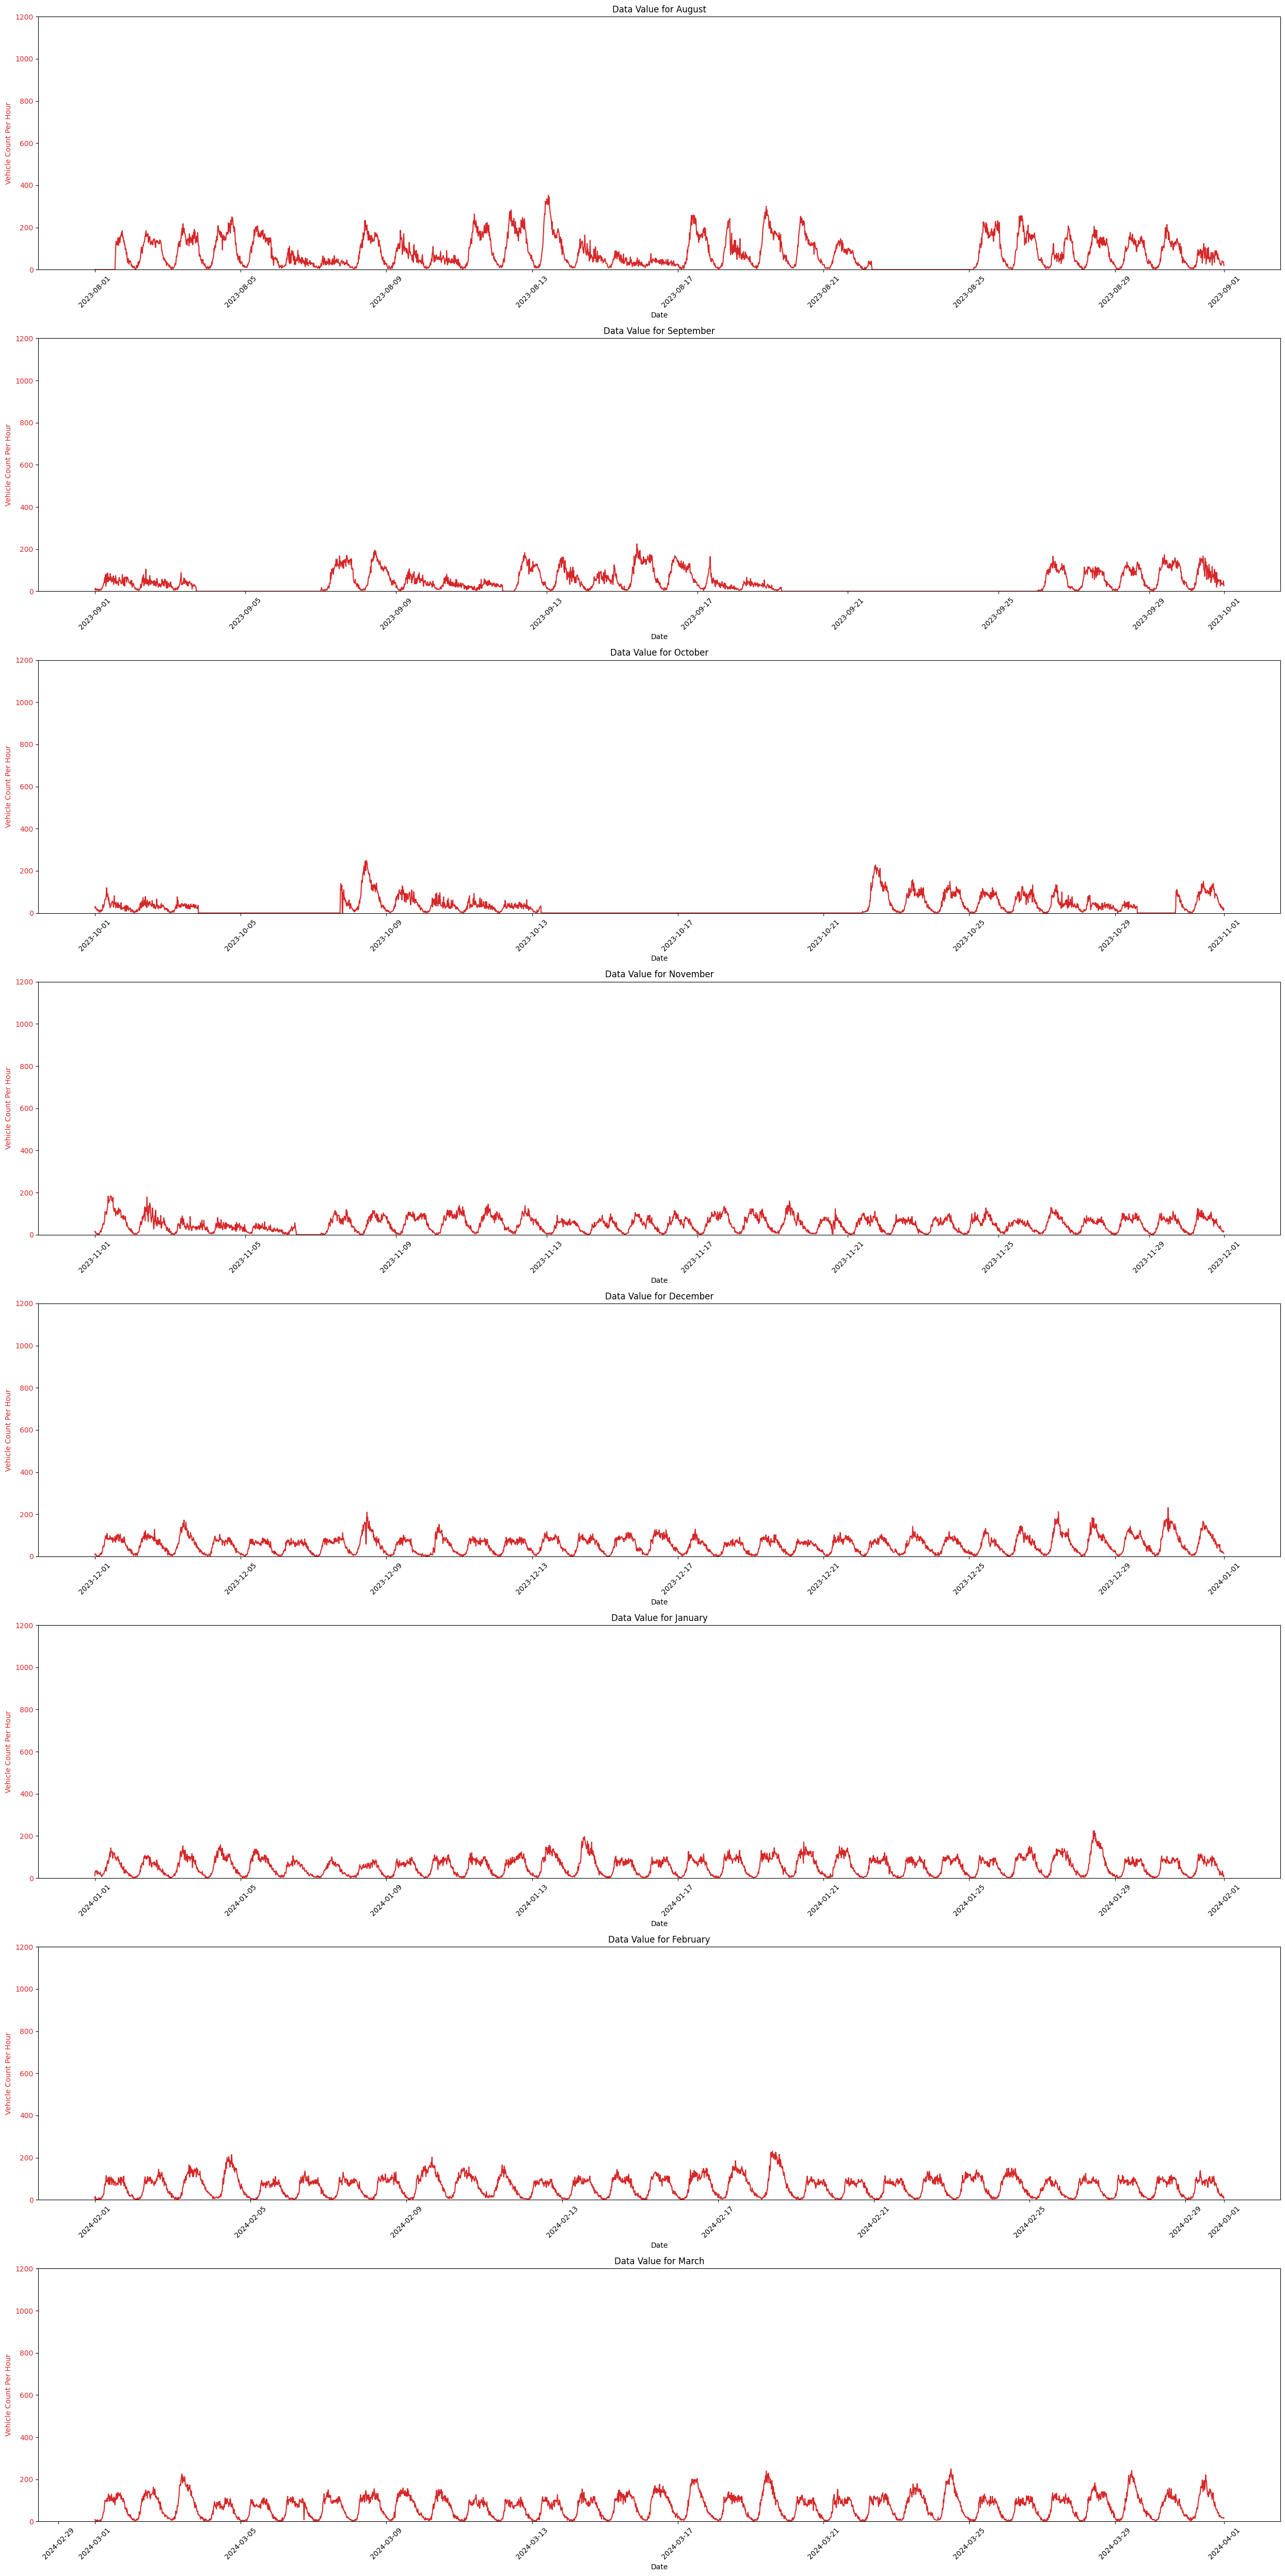

In [47]:
# Set up the figure size and layout
plt.figure(figsize=(25, 50))

# Names of the months for labeling purposes
month_names = ['August', 'September', 'October', 'November', 'December', 'January', 'February', 'March']

# Indices of the months you want to plot (exclude March to July)
months_to_plot = [8, 9, 10, 11, 12, 1, 2, 3]

for i, month in enumerate(months_to_plot, start=1):
    ax1 = plt.subplot(8, 1, i)  # Create a subplot for each month and get the first axis
    
    # Filter data for the current month
    month_data = df[df['month'] == month]
    
    # Plotting vehicle count per hour on the primary y-axis
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Vehicle Count Per Hour', color=color)
    ax1.plot(month_data['DateTime'], month_data['vehicle_count_per_hour'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim([0, 1200])  # Adjust y-axis to always have a max of 1200 for vehicle count
    

    plt.title(f'Data Value for {month_names[i-1]}')
    plt.xticks(rotation=45)  # Rotate date labels for better readability
    plt.tight_layout()  # Adjust subplots to fit in the figure area

plt.show()

### Normilization

In [60]:
# Using One-Hot Encoding and MinMaxScaler

# Identify Variable Types
numeric_columns = [
    'vehicle_count_per_hour', 'temp',
    'feelslike', 'humidity', 'dew', 'precip', 'precipprob',
    'windgust', 'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover',
    'solarradiation', 'solarenergy', 'uvindex'
]

categorical_columns = ['conditions']

# Normalize Numeric Variables
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns].fillna(0))

# One-Hot Encode Categorical Variables
# Set drop=None to keep all categories
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(df[categorical_columns])
encoded_features = encoder.get_feature_names_out(categorical_columns)
df = df.drop(categorical_columns, axis=1)
df[encoded_features] = encoded_data

# Your dataset is now normalized and encoded
print(df.head())
df.head(150)
# Save the modified DataFrame to an Excel file
df.to_excel('10_Normalization.xlsx', index=False)


             DateTime  vehicle_count_per_hour      temp  feelslike  humidity  \
0 2023-08-01 00:00:00                     0.0  0.705036   0.741935  0.694996   
1 2023-08-01 00:15:00                     0.0  0.705036   0.741935  0.694996   
2 2023-08-01 00:30:00                     0.0  0.705036   0.741935  0.694996   
3 2023-08-01 00:45:00                     0.0  0.705036   0.741935  0.694996   
4 2023-08-01 01:00:00                     0.0  0.701439   0.732258  0.686289   

        dew  precip  precipprob  windgust  windspeed  ...  day_of_week  month  \
0  0.883721     0.0         0.0  0.261616   0.467509  ...            2      8   
1  0.883721     0.0         0.0  0.261616   0.467509  ...            2      8   
2  0.883721     0.0         0.0  0.261616   0.467509  ...            2      8   
3  0.883721     0.0         0.0  0.261616   0.467509  ...            2      8   
4  0.872093     0.0         0.0  0.207071   0.351986  ...            2      8   

   day_of_year  Month  condition

### Feature Selection

                                   DateTime  vehicle_count_per_hour      temp  \
DateTime                           1.000000                0.107407 -0.810759   
vehicle_count_per_hour             0.107407                1.000000  0.082548   
temp                              -0.810759                0.082548  1.000000   
feelslike                         -0.803633                0.088594  0.995413   
humidity                           0.280224               -0.292080 -0.489262   
dew                               -0.744034               -0.089691  0.820737   
precip                             0.040626                0.007133 -0.036801   
precipprob                         0.063841               -0.038225 -0.150666   
windgust                           0.176013                0.108823 -0.046913   
windspeed                          0.151883                0.102348 -0.040511   
winddir                            0.017248               -0.014836 -0.112050   
pressure                    

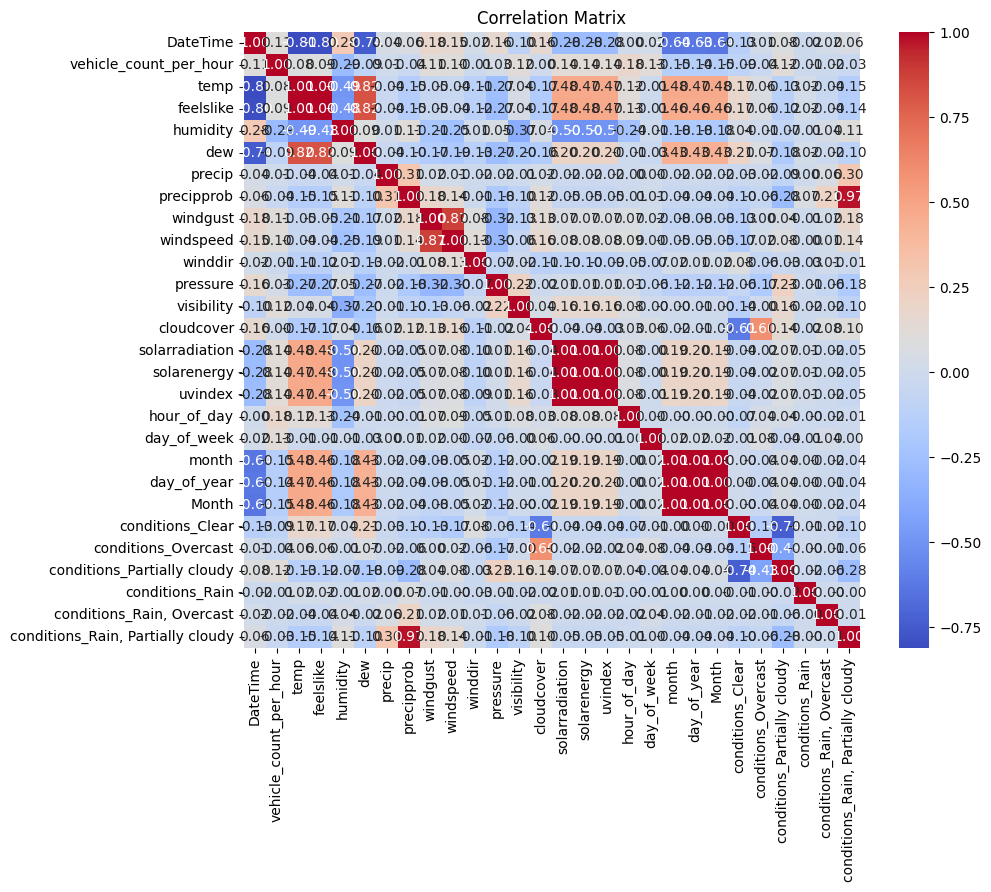

In [51]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Display the correlation matrix
print(corr_matrix)

# For a better visual understanding, you can plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title("Correlation Matrix")
plt.show()

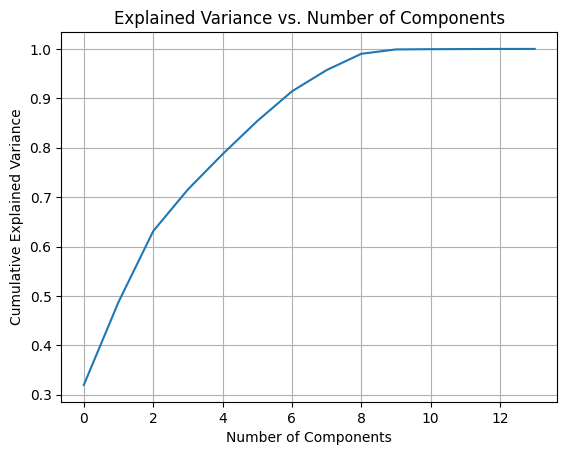

Optimal number of components to retain 90% variance: 7
   Principal Component 1  Principal Component 2  Principal Component 3  \
0               1.116408              -1.367215              -2.541142   
1               1.116408              -1.367215              -2.541142   
2               1.116408              -1.367215              -2.541142   
3               1.116408              -1.367215              -2.541142   
4               1.016191              -1.910809              -2.244606   

   Principal Component 4  Principal Component 5  Principal Component 6  \
0               0.542983              -0.222292               0.333921   
1               0.542983              -0.222292               0.333921   
2               0.542983              -0.222292               0.333921   
3               0.542983              -0.222292               0.333921   
4               0.362257              -0.174109               0.410004   

   Principal Component 7  
0               1.547589  
1

In [52]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Identify numeric columns for PCA (based on domain knowledge and feature relevance)
numeric_features = ['vehicle_count_per_hour', 'temp', 'feelslike', 
                    'humidity', 'dew', 'precip', 'windgust', 'windspeed', 'pressure', 
                    'visibility', 'cloudcover', 'solarradiation', 'solarenergy', 'uvindex']

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numeric_features])

# Apply PCA without specifying number of components initially
pca = PCA()
pca.fit(scaled_data)

# Plot cumulative explained variance to determine optimal number of components
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

# Determine the optimal number of components based on a chosen threshold (e.g., 90%)
optimal_components = np.argmax(cumulative_explained_variance >= 0.90) + 1
print(f"Optimal number of components to retain 90% variance: {optimal_components}")

# Re-run PCA with the optimal number of components
pca_optimal = PCA(n_components=optimal_components)
principal_components_optimal = pca_optimal.fit_transform(scaled_data)

# Convert to DataFrame for easier handling
pca_df_optimal = pd.DataFrame(data=principal_components_optimal, 
                              columns=[f'Principal Component {i+1}' for i in range(optimal_components)])

# Display the resulting DataFrame
print(pca_df_optimal.head())

# Optionally, examine the variance explained by each principal component
print(f"Explained variance by component: {pca_optimal.explained_variance_ratio_}")


In [ ]:
# Define the threshold as a percentage of maximum variance
threshold = 0.02  # Example threshold of 1%

selector = VarianceThreshold(threshold=(threshold * (1 - threshold)))
selector.fit(df[numeric_features])

# Get the indices of the features that are being kept
features_to_keep_indices = selector.get_support(indices=True)
# Get the feature names
features_to_keep_names = df[numeric_features].columns[features_to_keep_indices]

# Print the names of the features that are kept
print("Features to keep based on threshold of variance:")
print(features_to_keep_names)

# Alternatively, print the names of the features that are removed
features_to_remove = df[numeric_features].columns[~selector.get_support()]
print("\nFeatures removed due to low variance:")
print(features_to_remove)

# Transform dataset to only include features with variance above the threshold
df_low_variance = df[features_to_keep_names]




# Calculate the correlation matrix
corr_matrix = df.corr()

# Get the correlation of all features with 'vehicle_count_per_hour'
vehicle_correlations = corr_matrix['vehicle_count_per_hour'].sort_values(ascending=False)

# Print the correlations
print("Correlation of features with 'vehicle_count_per_hour':")
print(vehicle_correlations)


##### chi-square test?

## Phase 3 - Model Training

### Model Training

##### Splitting of data

In [61]:
# Load the data
df = pd.read_excel('10_Normalization.xlsx')

# Assuming the DataFrame df has a time column that we set as the index
# and a target variable column named 'vehicle_count_per_hour'

# Convert the index to a datetime object if it's not already
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

# The target variable
y = df['vehicle_count_per_hour']

# Define the number of splits for TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Placeholder for the Mean Squared Errors
mse_scores = []

# Iterate over each time series split
for train_index, test_index in tscv.split(y):
    # Split the data into the training and test sets
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the ARIMA model (using an example order of (1, 1, 1))
    # The order should ideally be determined using model selection techniques
    model = ARIMA(y_train, order=(1, 1, 1))
    model_fit = model.fit()

    # Make predictions
    predictions = model_fit.forecast(steps=len(y_test))

    # Calculate the Mean Squared Error for the current fold
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append(mse)

# Calculate the average MSE over all folds
average_mse = sum(mse_scores) / n_splits

# Output the MSE for each fold and the average MSE
mse_scores, average_mse



C:\Users\belli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
C:\Users\belli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
C:\Users\belli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
C:\Users\belli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\Lo

([0.014913992896235118,
  0.03037529260378925,
  0.023663596120252844,
  0.017680269489953913,
  0.02216546427939073],
 0.02175972307792437)

In [75]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Assuming scaled_data is your standardized dataset and df has your original data
pca_optimal = PCA(n_components=8)
principal_components_optimal = pca_optimal.fit_transform(scaled_data)

# Convert principal components to a DataFrame
pca_df_optimal = pd.DataFrame(data=principal_components_optimal, 
                              columns=[f'Principal Component {i+1}' for i in range(8)])

# Assuming 'date' is the time series index
pca_df_optimal['date'] = df['date']
pca_df_optimal.set_index('date', inplace=True)

# Use 80% of the data for training and 20% for testing
train_size = int(len(pca_df_optimal) * 0.8)
train_data, test_data = pca_df_optimal[:train_size], pca_df_optimal[train_size:]

# Define ARIMA order
order = (5, 1, 0)  # Example order, should be tuned based on your data

# Fit ARIMA model on each principal component and make predictions
for component in pca_df_optimal.columns:
    series_train = train_data[component]
    series_test = test_data[component]
    
    # Fit the model
    model_fit = ARIMA(series_train, order=order).fit()
    
    # Make predictions
    predictions = model_fit.forecast(steps=len(series_test))
    
    # Evaluate predictions
    mae = mean_absolute_error(series_test, predictions)
    mse = mean_squared_error(series_test, predictions)
    rmse = np.sqrt(mse)
    
    print(f"Accuracy for {component}:")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    
    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(series_train.index, series_train, label='Training Data')
    plt.plot(series_test.index, series_test, label='Actual Data')
    plt.plot(series_test.index, predictions, label='Predicted Data', color='red')
    plt.title(f'Actual vs Predicted for {component}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9559.416, Time=2.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10442.350, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10274.708, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10325.341, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10440.354, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9978.412, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10040.030, Time=0.57 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8929.116, Time=3.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10008.633, Time=0.73 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=9521.748, Time=4.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.58 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=9557.005, Time=2.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=9154.000, Time=3.12 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=9558.807, Time=3.80 sec
 ARIMA(3,1,2)(0,0,0)[0]         

## Data Preperation

Training with parameters: {'units': 50, 'dense_units': 50, 'epochs': 25, 'learning_rate': 0.001, 'batch_size': 16, 'activation_function': 'relu'}
Epoch 1/25
976/976 [==============================] - 3s 2ms/step - loss: 0.0199 - val_loss: 0.0180 - lr: 0.0010
Epoch 2/25
976/976 [==============================] - 2s 2ms/step - loss: 0.0181 - val_loss: 0.0168 - lr: 0.0010
Epoch 3/25
976/976 [==============================] - 2s 2ms/step - loss: 0.0174 - val_loss: 0.0154 - lr: 0.0010
Epoch 4/25
976/976 [==============================] - 2s 2ms/step - loss: 0.0166 - val_loss: 0.0140 - lr: 0.0010
Epoch 5/25
976/976 [==============================] - 2s 2ms/step - loss: 0.0157 - val_loss: 0.0152 - lr: 0.0010
Epoch 6/25
976/976 [==============================] - 2s 2ms/step - loss: 0.0146 - val_loss: 0.0145 - lr: 0.0010
Epoch 7/25
976/976 [==============================] - 2s 2ms/step - loss: 0.0131 - val_loss: 0.0153 - lr: 5.0000e-04
Epoch 8/25
976/976 [==============================] - 2s 2m

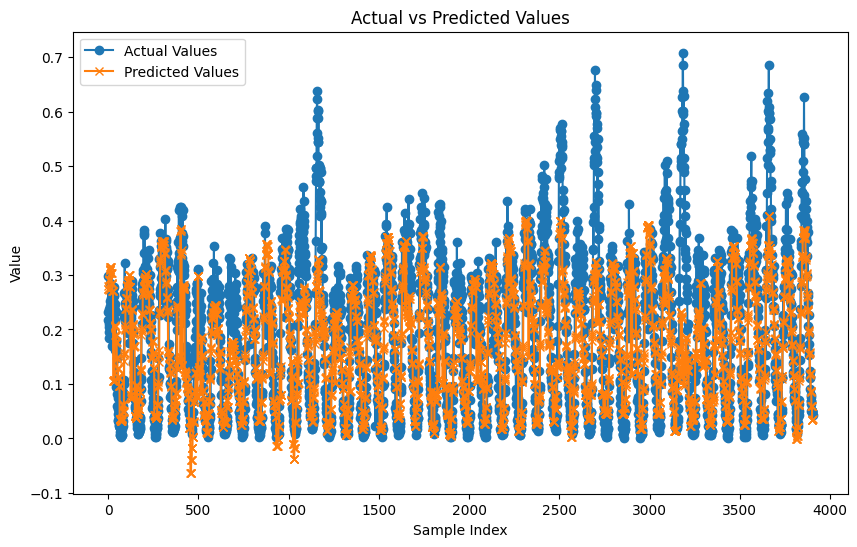

In [70]:
import numpy as np
import os
import datetime
import itertools
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from keras_tuner import RandomSearch, HyperParameters
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the parameter grid for grid search
param_grid_lstm = {
    'units': [50, 100, 150],
    'dense_units': [50, 100],
    'epochs': [25, 50],
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32, 64],
    'activation_function': ['relu', 'tanh']
}

def train_and_evaluate_model_lstm(X_train, y_train, X_test, y_test, **params):
    log_dir = os.path.join("logs_24052024", "lstm", datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_" + "_".join(f"{k}{v}" for k, v in params.items()))
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    model = Sequential([
        LSTM(units=params['units'], activation=params['activation_function'], input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(params['dense_units'], activation=params['activation_function']),
        Dropout(0.5),
        Dense(1)
    ])
    model.compile(loss="mse", optimizer=Adam(learning_rate=params['learning_rate']))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)
    
    model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_split=0.2, callbacks=[early_stopping, tensorboard_callback, reduce_lr])
    
    y_pred = model.predict(X_test).flatten()
    score = model.evaluate(X_test, y_test, verbose=0)
    return score, y_pred

# Initialize best score and params
best_score = float('inf')
best_params = None
best_predictions = None

# Assuming X_train, X_test, y_train, y_test are already defined and properly shaped
# Reshape data to 3D shape required by LSTM: (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train, axis=-1) if len(X_train.shape) == 2 else X_train
X_test_reshaped = np.expand_dims(X_test, axis=-1) if len(X_test.shape) == 2 else X_test

# Grid search over all combinations of parameters in the LSTM grid
for combination in itertools.product(*param_grid_lstm.values()):
    params = dict(zip(param_grid_lstm.keys(), combination))
    print(f"Training with parameters: {params}")
    
    try:
        score, predictions = train_and_evaluate_model_lstm(X_train=X_train_reshaped, y_train=y_train, X_test=X_test_reshaped, y_test=y_test, **params)

        if score < best_score:
            best_score = score
            best_params = params
            best_predictions = predictions
    except Exception as e:
        print(f"Error occurred with parameters {params}: {e}")

print(f"Best Score: {best_score}")
print(f"Best Parameters: {best_params}")

# Define thresholds for categorization based on data distribution
thresholds = np.quantile(y_train, [0.2, 0.4, 0.6, 0.8])

def categorize(values, thresholds):
    categories = np.digitize(values, bins=thresholds, right=True)
    category_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    return np.array([category_labels[cat] for cat in categories])

# Categorize predictions and actual values
predicted_categories = categorize(best_predictions, thresholds)
actual_categories = categorize(y_test, thresholds)

# Generate the confusion matrix
cm = confusion_matrix(actual_categories, predicted_categories)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', classification_report(actual_categories, predicted_categories))

# Calculate and print MAE, RMSE, and MSE
mae = mean_absolute_error(y_test, best_predictions)
mse = mean_squared_error(y_test, best_predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', marker='o')
plt.plot(range(len(best_predictions)), best_predictions, label='Predicted Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()


### GRU

Training with parameters: {'units': 32, 'dropout_rate': 0.3, 'recurrent_dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.01, 'batch_size': 32, 'activation_function': 'tanh'}
Epoch 1/100
488/488 [==============================] - 4s 4ms/step - loss: 0.0187 - val_loss: 0.0173 - lr: 0.0100
Epoch 2/100
488/488 [==============================] - 2s 3ms/step - loss: 0.0133 - val_loss: 0.0130 - lr: 0.0100
Epoch 3/100
488/488 [==============================] - 2s 3ms/step - loss: 0.0109 - val_loss: 0.0118 - lr: 0.0100
Epoch 4/100
488/488 [==============================] - 1s 3ms/step - loss: 0.0101 - val_loss: 0.0136 - lr: 0.0100
Epoch 5/100
488/488 [==============================] - 1s 3ms/step - loss: 0.0088 - val_loss: 0.0144 - lr: 0.0100
Epoch 6/100
488/488 [==============================] - 1s 3ms/step - loss: 0.0071 - val_loss: 0.0108 - lr: 0.0050
Epoch 7/100
488/488 [==============================] - 1s 3ms/step - loss: 0.0067 - val_loss: 0.0109 - lr: 0.0050
Epoch 8/100
488/488 [==

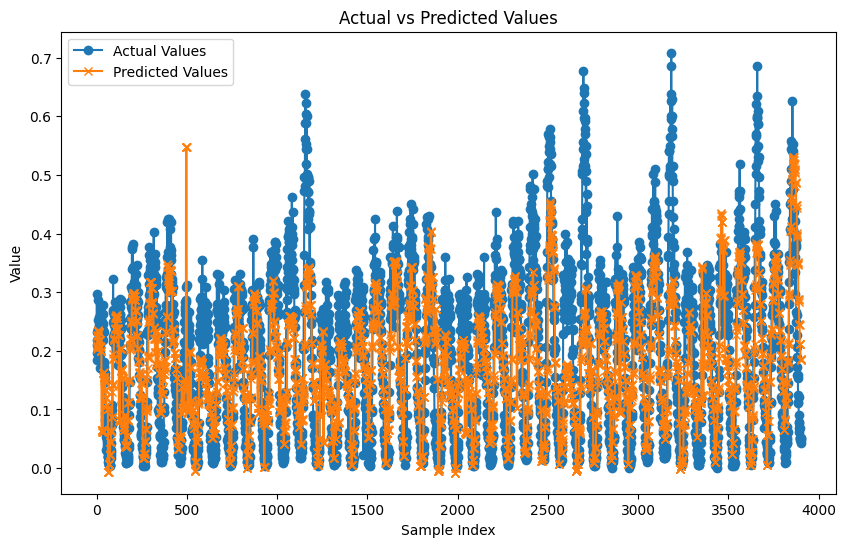

In [67]:
import numpy as np
import os
import datetime
import itertools
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from keras_tuner import RandomSearch, HyperParameters
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the parameter grid for grid search
param_grid_gru = {
    'units': [32],
    'dropout_rate': [0.3, 0.2],
    'recurrent_dropout_rate': [0.3, 0.2],
    'epochs': [100, 50],
    'learning_rate': [0.01, 0.001],
    'batch_size': [32, 64],
    'activation_function': ['tanh'],
}

def train_and_evaluate_model_gru(X_train, y_train, X_test, y_test, **params):
    log_dir = os.path.join("logs_24052024", "gru", datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_" + "_".join(f"{k}{v}" for k, v in params.items()))
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    model = Sequential([
        GRU(units=params['units'], activation=params['activation_function'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(params['dropout_rate']),
        GRU(units=params['units'], activation=params['activation_function']),
        Dropout(params['dropout_rate']),
        Dense(1)
    ])
    model.compile(loss="mse", optimizer=Adam(learning_rate=params['learning_rate']))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)
    
    model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_split=0.2, callbacks=[early_stopping, tensorboard_callback, reduce_lr])
    
    y_pred = model.predict(X_test).flatten()
    score = model.evaluate(X_test, y_test, verbose=0)
    return score, y_pred

# Initialize best score and params
best_score = float('inf')
best_params = None
best_predictions = None

# Assuming X_train, X_test, y_train, y_test are already defined and properly shaped
# Reshape data to 3D shape required by GRU: (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train, axis=-1) if len(X_train.shape) == 2 else X_train
X_test_reshaped = np.expand_dims(X_test, axis=-1) if len(X_test.shape) == 2 else X_test

# Grid search over all combinations of parameters in the GRU grid
for combination in itertools.product(*param_grid_gru.values()):
    params = dict(zip(param_grid_gru.keys(), combination))
    print(f"Training with parameters: {params}")
    
    score, predictions = train_and_evaluate_model_gru(X_train=X_train_reshaped, y_train=y_train, X_test=X_test_reshaped, y_test=y_test, **params)

    if score < best_score:
        best_score = score
        best_params = params
        best_predictions = predictions

print(f"Best Score: {best_score}")
print(f"Best Parameters: {best_params}")

# Define thresholds for categorization based on data distribution
thresholds = np.quantile(y_train, [0.2, 0.4, 0.6, 0.8])

def categorize(values, thresholds):
    categories = np.digitize(values, bins=thresholds, right=True)
    category_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    return np.array([category_labels[cat] for cat in categories])

# Categorize predictions and actual values
predicted_categories = categorize(best_predictions, thresholds)
actual_categories = categorize(y_test, thresholds)

# Generate the confusion matrix
cm = confusion_matrix(actual_categories, predicted_categories)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', classification_report(actual_categories, predicted_categories))

# Calculate and print MAE, RMSE, and MSE
mae = mean_absolute_error(y_test, best_predictions)
mse = mean_squared_error(y_test, best_predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', marker='o')
plt.plot(range(len(best_predictions)), best_predictions, label='Predicted Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()


### 1D CNN

Training with parameters: {'filters': 16, 'kernel_size': 3, 'dense_units': 50, 'epochs': 25, 'learning_rate': 0.001, 'batch_size': 16, 'activation_function': 'relu'}
Epoch 1/25
976/976 [==============================] - 1s 949us/step - loss: 0.0151 - val_loss: 0.0067 - lr: 0.0010
Epoch 2/25
976/976 [==============================] - 1s 864us/step - loss: 0.0114 - val_loss: 0.0056 - lr: 0.0010
Epoch 3/25
976/976 [==============================] - 1s 862us/step - loss: 0.0103 - val_loss: 0.0061 - lr: 0.0010
Epoch 4/25
976/976 [==============================] - 1s 878us/step - loss: 0.0098 - val_loss: 0.0063 - lr: 0.0010
Epoch 5/25
976/976 [==============================] - 1s 852us/step - loss: 0.0090 - val_loss: 0.0062 - lr: 5.0000e-04
Epoch 6/25
976/976 [==============================] - 1s 855us/step - loss: 0.0087 - val_loss: 0.0066 - lr: 5.0000e-04
Epoch 7/25
122/122 [==============================] - 0s 504us/step
Training with parameters: {'filters': 16, 'kernel_size': 3, 'dense_u

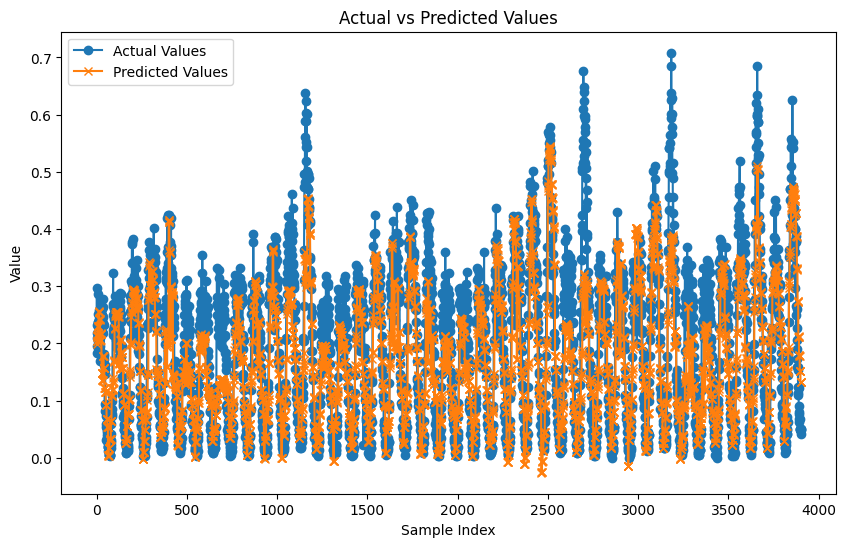

In [68]:
import numpy as np
import os
import datetime
import itertools
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from keras_tuner import RandomSearch, HyperParameters
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the parameter grid for grid search
param_grid_cnn = {
    'filters': [16, 32, 64],
    'kernel_size': [3, 5, 7],
    'dense_units': [50, 100],
    'epochs': [25, 50],
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32, 64],
    'activation_function': ['relu', 'tanh']
}

def train_and_evaluate_model_cnn(X_train, y_train, X_test, y_test, **params):
    log_dir = os.path.join("logs_24052024", "cnn", datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_" + "_".join(f"{k}{v}" for k, v in params.items()))
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    model = Sequential([
        Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation=params['activation_function'], input_shape=(X_train.shape[1], X_train.shape[2])),
        Flatten(),
        Dense(params['dense_units'], activation=params['activation_function']),
        Dropout(0.5),
        Dense(1)
    ])
    model.compile(loss="mse", optimizer=Adam(learning_rate=params['learning_rate']))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)
    
    model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_split=0.2, callbacks=[early_stopping, tensorboard_callback, reduce_lr])
    
    y_pred = model.predict(X_test).flatten()
    score = model.evaluate(X_test, y_test, verbose=0)
    return score, y_pred

# Initialize best score and params
best_score = float('inf')
best_params = None
best_predictions = None

# Assuming X_train, X_test, y_train, y_test are already defined and properly shaped
# Reshape data to 3D shape required by 1D CNN: (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train, axis=-1) if len(X_train.shape) == 2 else X_train
X_test_reshaped = np.expand_dims(X_test, axis=-1) if len(X_test.shape) == 2 else X_test

# Grid search over all combinations of parameters in the 1D CNN grid
for combination in itertools.product(*param_grid_cnn.values()):
    params = dict(zip(param_grid_cnn.keys(), combination))
    print(f"Training with parameters: {params}")
    
    score, predictions = train_and_evaluate_model_cnn(X_train=X_train_reshaped, y_train=y_train, X_test=X_test_reshaped, y_test=y_test, **params)

    if score < best_score:
        best_score = score
        best_params = params
        best_predictions = predictions

print(f"Best Score: {best_score}")
print(f"Best Parameters: {best_params}")

# Define thresholds for categorization based on data distribution
thresholds = np.quantile(y_train, [0.2, 0.4, 0.6, 0.8])

def categorize(values, thresholds):
    categories = np.digitize(values, bins=thresholds, right=True)
    category_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    return np.array([category_labels[cat] for cat in categories])

# Categorize predictions and actual values
predicted_categories = categorize(best_predictions, thresholds)
actual_categories = categorize(y_test, thresholds)

# Generate the confusion matrix
cm = confusion_matrix(actual_categories, predicted_categories)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', classification_report(actual_categories, predicted_categories))

# Calculate and print MAE, RMSE, and MSE
mae = mean_absolute_error(y_test, best_predictions)
mse = mean_squared_error(y_test, best_predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', marker='o')
plt.plot(range(len(best_predictions)), best_predictions, label='Predicted Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()


### Model Selection

## Phase 4 - Model Testing and Evaluation

### Model Testing

### Model Evaluation